## Imports

In [1]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping, LRScheduler

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import phate

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt

import numpy as np


from src.models.TurbulenceNetwork import TurbulenceNetwork
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device: ", device)

%load_ext autoreload
%autoreload 2


Device:  cuda:0


## Misc Utilities

In [2]:
class RMSELoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(RMSELoss, self).__init__()
        self.eta = 1e-8

    def forward(self, y_pred, y_true):
        l = torch.sqrt(torch.mean(torch.pow((y_true - y_pred), 2)))

        return l


## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:83: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


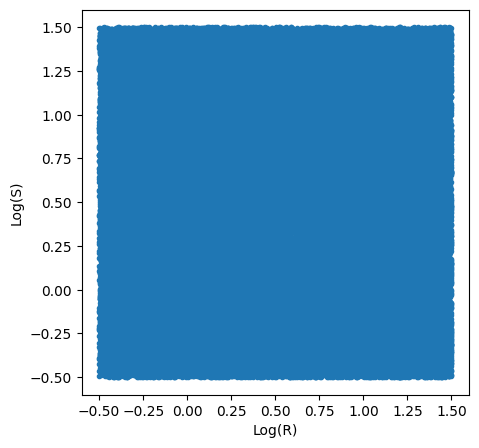

In [10]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 1.5)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 300, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)


## Network Training

In [11]:
# Defining model parameters
checkpoint_dir = './Model_Checkpoints/'

callbacks = [EarlyStopping(patience=15, threshold=0.0001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
            Checkpoint(monitor='valid_loss_best', f_params='TurbulenceNetwork.pt', dirname=checkpoint_dir)
]

net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 3,
        "h_dim": 20,
        "dropout": 0.00,
}

train_params = {
        "criterion": nn.MSELoss,
        "optimizer": torch.optim.Adam,
        "optimizer__weight_decay": 0.00001,
        "lr": 0.0005,
        "batch_size": 64,
        "max_epochs": 100,
        "device": device,
        "iterator_train__shuffle": True,
        "iterator_train__num_workers": 4,
        "iterator_train__pin_memory": True,
        "iterator_valid__shuffle": False,
        "iterator_valid__num_workers": 4,
        "iterator_valid__pin_memory": True,
        "verbose": 0,
        "callbacks": callbacks,
        "warm_start": True
}

In [12]:
x_scaler = StandardScaler().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train)
y_train = torch.tensor(y_scaled_train)


x_test = torch.tensor(x_scaler.transform(etas_test))
y_test = torch.tensor(y_scaler.transform(gs_test))

In [13]:
test_criteria = RMSELoss()
num_networks = 4
num_checkpoints = 70
epoch_per_checkpoint = 1
test_preds = []
run_numbers = []


for i in range(num_networks):
        callbacks = [EarlyStopping(patience=15, threshold=0.0001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
                #Checkpoint(monitor='valid_loss_best', f_params=f'TurbulenceNetwork_{i}_{checkpoint}.pt', dirname='./Model_Checkpoints/'),
                #LRScheduler(policy=ReduceLROnPlateau, monitor='valid_loss', factor=0.5, patience=5, threshold=0.0001, threshold_mode='abs', mode='min', verbose=True)
        ]
        train_params['callbacks'] = callbacks
        train_params['max_epochs'] = epoch_per_checkpoint


        net = create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)

        test_preds.append(net.predict(x_test).flatten())
        run_numbers.append(i)

        print(f"Training network {i}")

        for checkpoint in range(num_checkpoints):
                print(f"\tCheckpoint {checkpoint}")
                net = net.fit(x_train, y_train)

                test_pred = net.predict(x_test)
                test_preds.append(test_pred.flatten())
                run_numbers.append(i)
        

## Adding reference outputs
test_preds.append(y_test.flatten())
run_numbers.append(num_networks)



Training network 0
	Checkpoint 0
	Checkpoint 1
	Checkpoint 2
	Checkpoint 3
	Checkpoint 4
	Checkpoint 5
	Checkpoint 6
	Checkpoint 7
	Checkpoint 8
	Checkpoint 9
	Checkpoint 10
	Checkpoint 11
	Checkpoint 12
	Checkpoint 13
	Checkpoint 14
	Checkpoint 15
	Checkpoint 16
	Checkpoint 17
	Checkpoint 18
	Checkpoint 19
	Checkpoint 20
	Checkpoint 21
	Checkpoint 22
	Checkpoint 23
	Checkpoint 24
	Checkpoint 25
	Checkpoint 26
	Checkpoint 27
	Checkpoint 28
	Checkpoint 29
	Checkpoint 30
	Checkpoint 31
	Checkpoint 32
	Checkpoint 33
	Checkpoint 34
	Checkpoint 35
	Checkpoint 36
	Checkpoint 37
	Checkpoint 38
	Checkpoint 39
	Checkpoint 40
	Checkpoint 41
	Checkpoint 42
	Checkpoint 43
	Checkpoint 44
	Checkpoint 45
	Checkpoint 46
	Checkpoint 47
	Checkpoint 48
	Checkpoint 49
	Checkpoint 50
	Checkpoint 51
	Checkpoint 52
	Checkpoint 53
	Checkpoint 54
	Checkpoint 55
	Checkpoint 56
	Checkpoint 57
	Checkpoint 58
	Checkpoint 59
	Checkpoint 60
	Checkpoint 61
	Checkpoint 62
	Checkpoint 63
	Checkpoint 64
	Checkpoint 65
	

# Compiling Runs

In [25]:
## Converting to numpy arrays
test_outputs = np.array(test_preds)
labels = np.array(run_numbers)

## Getting final test errors
test_errors = np.sqrt(np.mean((test_outputs - y_test.numpy().flatten())**2, axis=1))
final_errors_idx = np.arange(1, num_networks + 1)*(num_checkpoints+1) -1
final_errors = test_errors[final_errors_idx]


## Plotting the result colors
colors = ['Blues', 'Greens', 'Reds', 'Purples']

# Visualizing outputs

### TSNE

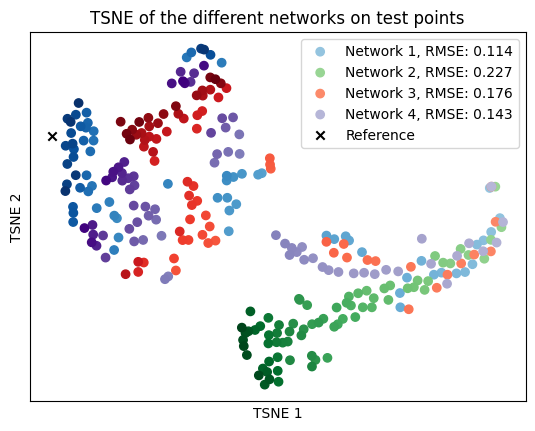

In [31]:
tsne = TSNE(n_components=2)
tsne_outputs = tsne.fit_transform(test_outputs)


for i in range(num_networks):
    c = np.linspace(.4, 1., num_checkpoints+1)
    plt.scatter(tsne_outputs[labels == i, 0], tsne_outputs[labels == i, 1], label=f"Network {i+1}, RMSE: {final_errors[i]:.3f}", c=c, cmap=colors[i], vmin=0, vmax=1)

plt.scatter(tsne_outputs[labels == num_networks, 0], tsne_outputs[labels == num_networks, 1], label="Reference", c='black', marker='x')

plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.xticks([])
plt.yticks([])
plt.title("TSNE of the different networks on test points")
plt.legend()
plt.show()

## PHATE

Calculating PHATE...
  Running PHATE on 285 observations and 900 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.37 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.40 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 0.05 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.01 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.09 seconds.
Calculated PHATE in 0.57 seconds.


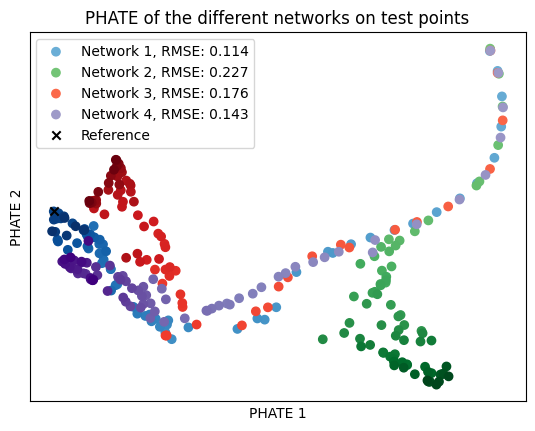

In [30]:
phate_op = phate.PHATE(n_components=2)
phate_outputs = phate_op.fit_transform(test_outputs)


for i in range(num_networks):
    c = np.linspace(.5, 1, num_checkpoints+1)
    plt.scatter(phate_outputs[labels == i, 0], phate_outputs[labels == i, 1], label=f"Network {i+1}, RMSE: {final_errors[i]:.3f}", c=c, cmap=colors[i], vmin=0, vmax=1)

plt.scatter(phate_outputs[labels == num_networks, 0], phate_outputs[labels == num_networks, 1], label="Reference", c='black', marker='x')

plt.title("PHATE of the different networks on test points")
plt.xlabel("PHATE 1")
plt.ylabel("PHATE 2")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()